**If you lost points on the last checkpoint you can get them back by responding to TA/IA feedback**  

Update/change the relevant sections where you lost those points, make sure you respond on GitHub Issues to your TA/IA to call their attention to the changes you made here.

Please update your Timeline... no battle plan survives contact with the enemy, so make sure we understand how your plans have changed.

# COGS 108 - Data Checkpoint

# Names

- Chinmay Bharambe 
- Anshul Govindu 
- Chaela Moraleja 
- Candice Sanchez 
- Praveen Sharma
 

# Research Question

Using UCSD enrollment data since Fall 2022, what combination of course characteristics (fill rate, capacity, quarter) and student factors (class standing/units, which determines the enrollment start date), best predict the number of open seats, for undergraduate courses, across all departments, during first and second-pass registrations? 

Can these predictions be used to develop a recommendation tool that optimizes first and second-pass course selection? 

## Background and Prior Work

This project attempts to address a major challenge for UCSD students: deciding which classes to enroll in during first and second pass. UCSD’s unique “pass” enrollment system turns course selection into more of an art than a science, often leaving students uncertain about their choices or failing to enroll in certain classes. This process also involves other unusual factors, such as major priority for CSE courses. Overall, there is a definite need for a tool that maximizes students' chances of securing their desired courses.

Upon initial research, we came across a research paper on using Machine Learning Methods for Course Enrollment Prediction <a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1) at San Diego State University. Their primary focus was to predict course enrollment rates based on demographic and academic performance data. Although these variables are not an element of our research, their methodology with student data is applicable. For example, they considered generic variables like major and prerequisites, and incorporated predictive models like classification and regression trees. Therefore, we can build on this analysis with similar ML and statistical approaches that consider more course and student-specific factors, such as the ones mentioned in the research question.

We also found two projects directly related to UCSD enrollment. This project collects data on individual classes at different points in time during each term, such as Fall 2022 or Winter 2023; each term’s data is contained within its own repository <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2). The project involved building a web scraping tool that scrapes web-reg about every 10 minutes and collects real-time data on information like enrolled, available, and waitlist spots. This not only offers a tool to collect our data in the future but also a great sample dataset from what has already been collected.

The second project was built using the aforementioned GitHub repositories  <a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3). Given a course, the website takes data from specific terms and plots the course availability as a time series across various registration milestones (senior first pass, junior second pass, etc). This offers a great initial visualization of the enrollment data, and our EDA would likely produce some similar graphs. However, our objective is to quantify the relationship between student/course factors and course availability and use our analysis to develop a recommendation system that helps students prioritize courses for first and second pass. Additionally, we plan on conducting our research on data collected across 11 quarters as compared to only one quarter shown in the stated project. We believe this is significant because there may exist quarterly patterns for some classes that a single quarter would fail to grasp.


1. <a name="cite_note-1"></a> [^](#cite_ref-1) https://par.nsf.gov/servlets/purl/10389427 
2. <a name="cite_note-2"></a> [^](#cite_ref-2) https://github.com/UCSD-Historical-Enrollment-Data
3. <a name="cite_note-3"></a> [^](#cite_ref-3) https://www.ucsdregistration.com


# Hypothesis


We predict that a course’s fill rate and student class standing would be the most influential combination of factors for students deciding on courses to enroll in and directly influence the number of open seats remaining during first and second pass. More specifically, we predict that courses with a higher fill rate and later enrollment period (due to higher class standing) would mean there are fewer seats available, and thus more likely to reach full capacity during first pass rather than second pass.

# Setup

The code block below consists of all the libraries and packages we use in this project

In [1]:
import pandas as pd
import numpy as np

import os
import io
import requests
import time
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data

## Dataset: UCSD Historical Enrollment Data

### Dataset Overview
  - Dataset Name: UCSD Historical Enrollment Data
  - Link to the dataset: https://github.com/UCSD-Historical-Enrollment-Data/UCSDHistEnrollData?tab=readme-ov-file
  - Number of observations: 11 quarters of data is recorded, the number of observations for subjects across the quarters is inconsistent.
  - Number of variables: There are 5 variables recorded: 
    - Time : The date and time the data was recorded
    - Enrolled : Number of students enrolled
    - Available : Number of seats available
    - Waitlisted : number of students waitlisted
    - Total : total seats available for the course 

This dataset was compiled using an automated web scraper that collected enrollment information from UC San Diego courses, spanning from Fall 2022 through to the current quarter (Winter 2025). The data is stored in CSV files that are hosted on GitHub.


### Dataset Structure and Organization

The UCSD Historical Enrollment Data is systematically organized within a GitHub repository, where each academic term is represented by a dedicated repository. This structure facilitates easy access to term-specific enrollment data. The data collection process is such that it captures enrollment statistics at regular intervals, providing a detailed view of how course enrollment evolves throughout the registration period.

The granularity of the data collection, which is approximately every 10 minutes during active enrollment periods, offers in depth insight into enrollment patterns, though for the purpose of our analysis, we will be implementing a more manageable sampling frequency. 

### Data Quality and Completeness

The dataset encompasses all undergraduate courses offered at UC San Diego across eleven quarters, providing a comprehensive view of enrollment patterns. While the number of observations varies between courses and quarters—primarily due to differences in course offerings and enrollment period durations — the consistency in variable recording ensures data compatibility across all terms.

### Data Processing Considerations
For our analysis, several key processing steps will be implemented:
1. Temporal aggregation to reduce unnecessary granularity while maintaining ensuring the trend of the data is captured accurately
2. Consistency of course codes to enable cross-quarter analysis
3. Enrollment phase demarcations (first pass, second pass, waitlist periods)
4. Creation of derived metrics such as fill rates to enhance analysis capabilities
5. Assignment of class standings (First-Year, Sophomore, Junior, Senior) to reflect enrollment priority hierarchies.

This dataset serves as an invaluable resource for understanding UC San Diego's enrollment patterns, offering insights that can inform both administrative decision-making and student course planning strategies.

### Collecting the Data

The initial approach to data collection from GitHub appeared straightforward, utilizing the pandas' read_csv() method to access the datasets hosted on GitHub. However, the extensive scope of the dataset—encompassing thousands of subjects with multiple observations across eleven academic quarters rendered this method inefficient, with projected data retrieval times exceeding twelve hours.

To enhance performance, we implemented several optimization strategies. First, we employed the chunking mechanism within read_csv() to process data in segments. While this modification yielded some improvement in processing speed, the enhancement was marginal for our requirements. Furthermore, we encountered limitations imposed by GitHub's API rate restrictions.<a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1). 

To address these constraints, we implemented parallel processing using the concurrent.futures package, enabling simultaneous retrieval of multiple files. This significantly improved operational efficiency<a name="cite_ref-1"></a><sup>1</sup>. Additionally, we found that GitHub's API authentication system offered substantially higher rate limits, 5,000 requests per hour, for authenticated users compared to 60 for unauthenticated users. Therefore we implementated authentication headers in our requests to effectively circumvent the restrictions.

A subsequent challenge emerged regarding data completeness. Our initial API implementation for retrieving directory contents was subject to GitHub's truncation limit of 999 files per directory, resulting in incomplete data collection. Through further research, we identified that the git/trees API provided access to the complete file directory, including previously truncated entries. This solution ensured we collected complete data<a name="cite_ref-2"></a><sup>2</sup>.

To optimize computational efficiency and eliminate redundant processing, we stored the collected data in enrollment_data.csv. The presence of this file in the working directory enables the system to skip the data collection process during subsequent notebook kernel restarts.

1. <a name="cite_note-1"></a> [^](#cite_ref-1) https://medium.com/@smrati.katiyar/introduction-to-concurrent-futures-in-python-009fe1d4592c
2. <a name="cite_note-2"></a> [^](#cite_ref-2) https://docs.github.com/en/rest/repos/contents?apiVersion=2022-11-28

In [2]:
# list of all the repo-links that host the data for each quarter in a csv file
repo_links = [
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2022Fall/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2023Winter/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2023Spring/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2023Fall/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Winter/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Spring/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Summer1/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Summer2/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Summer3/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Fall/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2025Winter/contents/overall',
      ]

quarter_names = ['FA 22','WI 23', 'SP 23', 'FA 23', 'WI 24', 'SP 24', 'S1 24', 'S2 24', 'S3 24', 'FA 24', 'WI 25']

In [3]:
# github token for adressing the limit on github api rates. 
# recommended to create an environment varaible to store this for improved security. Alternatively, one can simply add the github token below
GITHUB_TOKEN = 'put in your token'  

In [4]:

# check if the new enrollment data file already exists
if os.path.exists('enrollment_data.csv'):
    df = pd.read_csv('enrollment_data.csv') 
else:
    # this function processes the data quarter by quarter
    def process_quarter(repo_link, quarter_name):
        # try-except block to handle errors
        try:
            # extract repo name from the API URL
            repo_name = repo_link.split('/')[5]  
            
            # construct tree API URL to gett all the files that are hidden as well
            tree_url = f"https://api.github.com/repos/UCSD-Historical-Enrollment-Data/{repo_name}/git/trees/main?recursive=1"
            
            # add headers to account for GitHub API rate limiting
            headers = {
                'Accept': 'application/vnd.github.v3+json',
                'Authorization': f'token {GITHUB_TOKEN}'
            }
            
            # get the tree
            response = requests.get(tree_url, headers=headers)
            
            # if request was unsuccessful print error message
            if response.status_code != 200:
                print(f"failed to access {tree_url}")
                print(f"Response: {response.text}")
                return None
                
            # get all files from the 'overall' directory
            all_files = [item['path'].split('/')[-1] 
                        for item in response.json()['tree'] 
                        if item['path'].startswith('overall/') and item['path'].endswith('.csv')]
                        
            # process multiple files in parallel to make the process faster and more efficient
            dfs = []
            with ThreadPoolExecutor(max_workers=5) as executor:
                # create a list of futures where each future represents a file being processed
                futures = [executor.submit(process_file, file, repo_name, quarter_name) 
                        for file in all_files]
                
                # loop through completed futures and collect results
                for future in futures:  
                    try:
                        df = future.result()
                        if df is not None:
                            dfs.append(df)
                    except Exception as e:
                        # print error in case of an error
                        print(f"error in future: {str(e)}")
            
            # if dfs is not empty, concatenate all the dfs for that quarter and return that
            if dfs:
                return pd.concat(dfs, ignore_index=True)
            return None
            
        except Exception as e:
            # print error msg if it occurs
            print(f"error processing quarter {quarter_name}: {str(e)}")
            return None

    # function that reads the csv file and makes it into a df
    def process_file(file, repo_name, quarter_name):
        print(file)
        # try-except block to handle errors
        try:
            # convert file name to the format seen in the url
            file_url = file.replace(' ','%20')
            
            # raw csv file link
            raw_url = f"https://raw.githubusercontent.com/UCSD-Historical-Enrollment-Data/{repo_name}/main/overall/{file_url}"
            
            # add authentication headers
            headers = {
                'Accept': 'application/vnd.github.v3+json',
                'Authorization': f'token {GITHUB_TOKEN}'
            }
            
            # Read the csv files with authentication
            response = requests.get(raw_url, headers=headers)
            response.raise_for_status()
            
            # read csv file into a pandas df
            df = pd.read_csv(
                io.StringIO(response.text),
                sep=',',              # the separator
                encoding='utf-8',     # specify the character encoding
                parse_dates=['time'], # parse dates as datetime objects as they are being read to save time
                usecols=['time', 'enrolled', 'available', 'waitlisted', 'total'] # specify column names to improve efficiency
            )
            
            if not df.empty:
                # add course column that is readable
                df['course'] = file.replace('.csv', '').replace('%20',' ')
                # group df at a frequency of every 12 hrs to get 2 readings for each day
                df = df.groupby(pd.Grouper(key='time', freq='12h')).first().reset_index()
                # add a column that stores the quarter name
                df['quarter'] = quarter_name
                return df
            return None
            
        except Exception as e:
            # if there is an error, print it
            print(f"error processing {file}: {str(e)}")
            return None

    def load_data():
        # list that will store the df for every quarter
        all_quarter_dfs = []

        # loop through each quarter and process its data
        for repo_link, quarter_name in zip(repo_links, quarter_names):  
            # delay to avoid hitting githubs rate limits
            if all_quarter_dfs:
                time.sleep(5)

            # process the current quarters data   
            quarter_df = process_quarter(repo_link, quarter_name)

            # append data to all_quarter_dfs if df is not empty
            if quarter_df is not None:
                all_quarter_dfs.append(quarter_df)
                
                # save progress after each quarter in case the program crashes            
                temp_df = pd.concat(all_quarter_dfs, ignore_index=True)
                temp_df.to_csv('enrollment_data_temp.csv', 
                            index=False,
                            encoding='utf-8')
        
        # save the final complete dataset
        if all_quarter_dfs:
            combined_df = pd.concat(all_quarter_dfs, ignore_index=True)
            combined_df.to_csv('enrollment_data.csv', 
                            index=False,
                            encoding='utf-8')
            return combined_df
        return None

    # run the load_data function
    df = load_data()

The file created by the function load_data() was too large to upload onto GitHub (more than 150 mb) hence we uploaded it to google drive. 

The raw data we collected can be found here: https://drive.google.com/file/d/1Xv0GoHwTJ19rF9oBCIs7jF0etkzkJPhy/view?usp=drive_link

In [5]:
df

,time,enrolled,available,waitlisted,total,course,quarter
0,2022-05-18 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
1,2022-05-18 12:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
2,2022-05-19 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
3,2022-05-19 12:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
4,2022-05-20 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
...,...,...,...,...,...,...,...
3070123,2025-01-25 00:00:00,8.0,7.0,0.0,15.0,WES 269,WI 25
3070124,2025-01-25 12:00:00,8.0,7.0,0.0,15.0,WES 269,WI 25
3070125,2025-01-26 00:00:00,8.0,7.0,0.0,15.0,WES 269,WI 25
3070126,2025-01-31 00:00:00,8.0,7.0,0.0,15.0,WES 269,WI 25


### Data Processing

First, let's see if we have any missing values in our dataset.

In [6]:
# Look for missing values
df.isnull().sum()

time          0
enrolled      0
available     0
waitlisted    0
total         0
course        0
quarter       0
dtype: int64

Next, we need to ensure that all columns are of the right data type and consistently formatted.

In [7]:
# converting 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# converting 'enrolled', 'available', 'waitlisted', and 'total' columns to float (easier to handle)
df['enrolled'] = df['enrolled'].astype(float)
df['available'] = df['available'].astype(float)
df['waitlisted'] = df['waitlisted'].astype(float)
df['total'] = df['total'].astype(float)

# converting 'course' and 'quarter' columns to strings
df['course'] = df['course'].astype(str)
df['quarter'] = df['quarter'].astype(str)

In [8]:
df.dtypes

time          datetime64[ns]
enrolled             float64
available            float64
waitlisted           float64
total                float64
course                object
quarter               object
dtype: object

Now, all columns are correctly formatted in the appropriate data types.

While observing our raw data, we realized that there were some graduate level courses included in this datasets. Since our analysis focuses primarily on undergraduate enrollment, we will be working solely with undergraduate course and exclude all graduate courses.

In [9]:
# extract the course number and convert to integer
df['course_number'] = df['course'].str.extract('(\d+)').astype(int)

# filter out graduate courses where the number is >=200
df = df[df['course_number'] < 200]

# drop the temporary course_number column 
df = df.drop('course_number', axis=1)

df

,time,enrolled,available,waitlisted,total,course,quarter
0,2022-05-18 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
1,2022-05-18 12:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
2,2022-05-19 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
3,2022-05-19 12:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
4,2022-05-20 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
...,...,...,...,...,...,...,...
3069658,2025-01-25 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069659,2025-01-25 12:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069660,2025-01-26 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069661,2025-01-31 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25


In order to extract further information, we need to know when registration opens for each quarter.

In order to do this, we will scrape UCSD's publically available yearly "enrollment and registration calendars" to determine the first day of enrollment for each quarter.

In [10]:
calendar_links = [
    'https://blink.ucsd.edu/instructors/courses/enrollment/calendars/2022.html',    # 2022 - 2023
    'https://blink.ucsd.edu/instructors/courses/enrollment/calendars/2023.html',    # 2023 - 2024
    'https://blink.ucsd.edu/instructors/courses/enrollment/calendars/2024.html'     # 2024 - 2025
]

def process_calendar(link, yr):
    r = requests.get(link)
    soup = BeautifulSoup(r.content, 'html.parser')

    # The website has a table with every important date
    table = soup.find('table')

    # Store enrollment start dates w/ same formatting as the 'quarter' column of the df
    dates = {}

    # Iterate through table rows
    for row in table.find_all('tr'): 
        cells = row.find_all('td')
        if cells:
            label = cells[0].get_text(strip=True)
            if 'Enrollment begins' in label:
                dates['FA' + " " + str(yr)] = cells[1].get_text(strip=True) + "/" + str(yr)

                s = str(yr + 1)
                dates['WI' + " " + s] = cells[2].get_text(strip=True) + "/" + str(yr)

                if yr < 24: 
                    dates['SP' + " " + s] = cells[3].get_text(strip=True) + "/" + s

                if yr == 23:
                    dates['S1' + " " + s] = cells[4].get_text(strip=True) + "/" + s
                    dates['S2' + " " + s] = cells[4].get_text(strip=True) + "/" + s
                    dates['S3' + " " + s] = cells[4].get_text(strip=True) + "/" + s
                break
    return dates

enrollment_starts = {}
year = 22
for link in calendar_links:
    enrollment_starts.update(process_calendar(link, year))
    year += 1
enrollment_starts

{'FA 22': '5/20/22',
 'WI 23': '11/7/22',
 'SP 23': '2/18/23',
 'FA 23': '5/26/23',
 'WI 24': '11/14/23',
 'SP 24': '2/17/24',
 'S1 24': '4/15/24',
 'S2 24': '4/15/24',
 'S3 24': '4/15/24',
 'FA 24': '5/24/24',
 'WI 25': '11/12/24'}

Convert the month/day/year format into a datetime object for consistent formatting

In [11]:
for key in enrollment_starts:
    enrollment_starts[key] = pd.to_datetime(enrollment_starts[key], format='%m/%d/%y')

enrollment_starts

{'FA 22': Timestamp('2022-05-20 00:00:00'),
 'WI 23': Timestamp('2022-11-07 00:00:00'),
 'SP 23': Timestamp('2023-02-18 00:00:00'),
 'FA 23': Timestamp('2023-05-26 00:00:00'),
 'WI 24': Timestamp('2023-11-14 00:00:00'),
 'SP 24': Timestamp('2024-02-17 00:00:00'),
 'S1 24': Timestamp('2024-04-15 00:00:00'),
 'S2 24': Timestamp('2024-04-15 00:00:00'),
 'S3 24': Timestamp('2024-04-15 00:00:00'),
 'FA 24': Timestamp('2024-05-24 00:00:00'),
 'WI 25': Timestamp('2024-11-12 00:00:00')}

Now we can perform the following task.

- The dataset contains datapoints from before the enrollment period opens. This may skew the data, making it appear as if open slots are available for longer than they actually are.
- We will remove these datapoints.

In [12]:
df = df[df['quarter'].map(enrollment_starts) <= df['time']]
df

,time,enrolled,available,waitlisted,total,course,quarter
4,2022-05-20 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
5,2022-05-20 12:00:00,1.0,67.0,0.0,68.0,AAS 10,FA 22
6,2022-05-21 00:00:00,3.0,65.0,0.0,68.0,AAS 10,FA 22
7,2022-05-21 12:00:00,5.0,63.0,0.0,68.0,AAS 10,FA 22
8,2022-05-22 00:00:00,6.0,62.0,0.0,68.0,AAS 10,FA 22
...,...,...,...,...,...,...,...
3069658,2025-01-25 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069659,2025-01-25 12:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069660,2025-01-26 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069661,2025-01-31 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25


In [13]:
df['quarter'].value_counts()

quarter
FA 24    406836
FA 22    358434
FA 23    318676
WI 23    243772
WI 24    233293
SP 23    206777
SP 24    192047
WI 25    188815
S1 24     37034
S2 24     19261
S3 24      1859
Name: count, dtype: int64

We also need columns that measure enrollment priority (senior, junior...) and pass # (1, 2), as these are integral parts of our research question. These can easily be derived with respect to each quarter's enrollment start date.

In [14]:
# Enrollment start dates for incoming students
fa_fresh_start = {
    'FA 22' : pd.to_datetime("8-17-2022"),
    'FA 23' : pd.to_datetime("8-28-2023"),
    'FA 24' : pd.to_datetime("8-12-2024")
}

def registration_priority(date, quarter):

    # Ensure consistent formatting 
    enrollment_start_date = pd.to_datetime(enrollment_starts[quarter])
    date = pd.to_datetime(date)
    days = int((date - enrollment_start_date).days) # number of days since enrollment has been open
    
    pass_num = 0   
    priority = 0 

    # first week of registration is first pass                               
    if 0 <= days and days < 7:
        pass_num = 1            
        if days == 0:
            priority = 1    # first day of each pass is senior enrollment (1)
        elif days == 1:
            priority = 2    # second day = junior (2)
        elif days == 2: 
            priority = 3    # soph (3)
        else:
            priority = 4    # fresh (4)

    # second week is second pass
    elif 7 <= days and days < 14:
        pass_num = 2 
        if days == 7:
            priority = 1
        elif days == 8:
            priority = 2
        elif days == 9:
            priority = 3
        else:
            priority = 4 

    # afterwards, registration is open to all
    else:
        # these values are just placeholders to represent that anybody can enroll
        pass_num = 3 
        priority = 6        

    # Incoming freshman enrollment is unique
    if 'FA' in quarter:
        days = int((date - fa_fresh_start[quarter]).days)
        
        if 0 <= days and days < 7:
            pass_num = 1
            priority = 5
        elif 7 <= days and days < 14:
            pass_num = 2
            priority = 5
    
    return pass_num, priority

In [15]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
    df[['pass', 'priority']] = df.apply(lambda row: registration_priority(row['time'], row['quarter']), axis=1, result_type='expand')
df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority
4,2022-05-20 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,1
5,2022-05-20 12:00:00,1.0,67.0,0.0,68.0,AAS 10,FA 22,1,1
6,2022-05-21 00:00:00,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,2
7,2022-05-21 12:00:00,5.0,63.0,0.0,68.0,AAS 10,FA 22,1,2
8,2022-05-22 00:00:00,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3
...,...,...,...,...,...,...,...,...,...
3069658,2025-01-25 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25,3,6
3069659,2025-01-25 12:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25,3,6
3069660,2025-01-26 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25,3,6
3069661,2025-01-31 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25,3,6


In [16]:
df['priority'].value_counts()

priority
6    1845446
4     153061
5      92473
1      38840
3      38503
2      38481
Name: count, dtype: int64

We can see from the value counts that certain subsets are over-represented. It simply doesn't make sense to have so much data outside of first and second pass, when these are the focus of our question.

1. There is a disproportionate number of days of freshman priority (4). This is because we're considering all days after sophomore enrollment, but before the end of the week, to be freshman enrollment.

2. The same is true for incoming freshman enrollment (priorty 5).

3. The same is true for when enrollment is opened to all students (priority 6).

Realistically, we only need to know how many seats are available during the first day of someone's first pass, first day of their second pass, and first day of open enrollment. Anything beyond this will simply skew our predictive model.

In [17]:
# Find the first date for each group
first_dates = df.groupby(['quarter', 'pass', 'priority'])['time'].min().reset_index()

# Merge with the original df to keep all unique (quarter, pass, priority) entries on the first date
df = pd.merge(df, first_dates, on=['quarter', 'pass', 'priority', 'time'], how='inner')

df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority
0,2022-05-20,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,1
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,2
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,4
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,1
...,...,...,...,...,...,...,...,...,...
94275,2024-11-19,160.0,0.0,0.0,160.0,WCWP 10B,WI 25,2,1
94276,2024-11-20,160.0,0.0,2.0,160.0,WCWP 10B,WI 25,2,2
94277,2024-11-21,160.0,96.0,2.0,256.0,WCWP 10B,WI 25,2,3
94278,2024-11-22,161.0,95.0,1.0,256.0,WCWP 10B,WI 25,2,4


In [18]:
df['priority'].value_counts()

priority
4    19447
3    19428
2    19423
1    19417
6     9967
5     6598
Name: count, dtype: int64

In [19]:
df['pass'].value_counts()

pass
1    42841
2    41472
3     9967
Name: count, dtype: int64

This is much more representative of the analysis we want to do, which prioritizes senior to freshman registration during first and second pass. 

In [20]:
if not os.path.exists('new_enrollment_data.csv'):
    df.to_csv('new_enrollment_data.csv', index=False)


Lastly, we need to create a column that keeps track of the proportion of total seats that have been filled for each course, as this is also an integral part of our research question and could prove very useful in our analysis when observing trends in how quickly a class fills up. 

To do that, we will create a new column 'fill rate' that computes the proportion of filled seats as shown:

In [21]:
# Adding fill rate column
df["fill rate"] = df['enrolled'] / df['total']

df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate
0,2022-05-20,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,1,0.000000
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,2,0.044118
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3,0.088235
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,4,0.088235
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,1,0.470588
...,...,...,...,...,...,...,...,...,...,...
94275,2024-11-19,160.0,0.0,0.0,160.0,WCWP 10B,WI 25,2,1,1.000000
94276,2024-11-20,160.0,0.0,2.0,160.0,WCWP 10B,WI 25,2,2,1.000000
94277,2024-11-21,160.0,96.0,2.0,256.0,WCWP 10B,WI 25,2,3,0.625000
94278,2024-11-22,161.0,95.0,1.0,256.0,WCWP 10B,WI 25,2,4,0.628906


In [22]:
# checking for missing values
df.isnull().sum()

time             0
enrolled         0
available        0
waitlisted       0
total            0
course           0
quarter          0
pass             0
priority         0
fill rate     1838
dtype: int64

There seems to be a lot of missing values generated by the 'fill rate' column. Digging a little deeper, it seems that there are some observations in our dataset, as you can see below, where the total number of seats for the course is listed as 0.

In [23]:
# courses with 0 total seats
df[df['total'] == 0]

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate
266,2022-05-27,1.0,0.0,0.0,0.0,ANTH 10,FA 22,2,1,inf
267,2022-05-28,1.0,0.0,0.0,0.0,ANTH 10,FA 22,2,2,inf
268,2022-05-29,1.0,0.0,0.0,0.0,ANTH 10,FA 22,2,3,inf
269,2022-05-30,1.0,0.0,0.0,0.0,ANTH 10,FA 22,2,4,inf
403,2022-08-17,6.0,0.0,1.0,0.0,AWP 4A,FA 22,1,5,inf
...,...,...,...,...,...,...,...,...,...,...
93645,2024-11-19,37.0,0.0,0.0,0.0,USP 187,WI 25,2,1,inf
93646,2024-11-20,7.0,0.0,5.0,0.0,USP 187,WI 25,2,2,inf
93647,2024-11-21,26.0,0.0,10.0,0.0,USP 187,WI 25,2,3,inf
93961,2024-11-20,0.0,0.0,0.0,0.0,VIS 129E,WI 25,2,2,NaN


More surprisingly, a lot of these courses have values greater than 0 in the 'enrolled' and 'waitlisted' columns. This could be some sort of error on the webscraping process used to fetch data, or possibly an error on UCSD's course registration portal.

As a result, our calculation of fill rate must handle these values appropriately to avoid running into zero division errors and missing values. To do this, we created a helper function that fills in 0 for 'fill rate' in rows where 'total' is 0.

In [24]:
def get_fill_rate(row):
    # to avoid zero division errors
    if not row['total']:
        return 0.0
    else:
        return row['enrolled'] / row['total']


df["fill rate"] = df.apply(get_fill_rate, axis=1)

df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate
0,2022-05-20,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,1,0.000000
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,2,0.044118
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3,0.088235
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,4,0.088235
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,1,0.470588
...,...,...,...,...,...,...,...,...,...,...
94275,2024-11-19,160.0,0.0,0.0,160.0,WCWP 10B,WI 25,2,1,1.000000
94276,2024-11-20,160.0,0.0,2.0,160.0,WCWP 10B,WI 25,2,2,1.000000
94277,2024-11-21,160.0,96.0,2.0,256.0,WCWP 10B,WI 25,2,3,0.625000
94278,2024-11-22,161.0,95.0,1.0,256.0,WCWP 10B,WI 25,2,4,0.628906


In [25]:
# checking for missing values again
df.isnull().sum()

time          0
enrolled      0
available     0
waitlisted    0
total         0
course        0
quarter       0
pass          0
priority      0
fill rate     0
dtype: int64

Before we proceed with our analysis, we need to ensure that there are no other unusual or unnecessary data.

We can check this by getting some descriptive statistics.

In [26]:
# summary statistics
df.describe()

,time,enrolled,available,waitlisted,total,pass,priority,fill rate
count,94280,94280.000000,94280.000000,94280.000000,94280.000000,94280.000000,94280.000000,94280.000000
mean,2023-09-15 11:45:53.228680448,40.772476,432.687092,2.345779,473.173038,1.651315,3.045471,0.343424
min,2022-05-20 00:00:00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2023-02-19 00:00:00,1.000000,13.000000,0.000000,30.000000,1.000000,2.000000,0.025000
50%,2023-11-16 00:00:00,12.000000,31.000000,0.000000,60.000000,2.000000,3.000000,0.200000
75%,2024-04-29 00:00:00,40.000000,80.000000,0.000000,140.000000,2.000000,4.000000,0.616667
max,2024-11-26 00:00:00,2402.000000,289971.000000,584.000000,289971.000000,3.000000,6.000000,9.250000
std,NaN,86.075392,6579.055679,12.727712,6577.546827,0.662225,1.570168,0.361519


Observing the maximum values for 'available' and 'total' columns, it seems like there are some courses in our dataset where the total number of seats are over 280,000!

Generally, it is unlikely that there are courses with over 1000 seats, so these data points are likely outliers. As a result, we wil remove these rows from our dataset and only consider courses that have under 1000 seats.

In [27]:
df = df[df['total'] < 1000]
df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate
0,2022-05-20,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,1,0.000000
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,2,0.044118
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3,0.088235
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,4,0.088235
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,1,0.470588
...,...,...,...,...,...,...,...,...,...,...
94275,2024-11-19,160.0,0.0,0.0,160.0,WCWP 10B,WI 25,2,1,1.000000
94276,2024-11-20,160.0,0.0,2.0,160.0,WCWP 10B,WI 25,2,2,1.000000
94277,2024-11-21,160.0,96.0,2.0,256.0,WCWP 10B,WI 25,2,3,0.625000
94278,2024-11-22,161.0,95.0,1.0,256.0,WCWP 10B,WI 25,2,4,0.628906


Let's also ensure that the fill rate column has values that are appropriate (i.e. values range between 0 and 1), and remove the rows that have values outside that range. 

In [28]:
# filter rows with fill rate outside of range(0, 1)
df = df[(df['fill rate'] > 0) & (df['fill rate'] <= 1.1)]

In [29]:
# summary statistics
df.describe()

,time,enrolled,available,waitlisted,total,pass,priority,fill rate
count,72756,72756.000000,72756.000000,72756.000000,72756.000000,72756.000000,72756.000000,72756.000000
mean,2023-09-18 06:39:08.936170240,49.641954,63.209673,2.783496,112.810531,1.757463,3.315190,0.440022
min,2022-05-20 00:00:00,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.001001
25%,2023-02-20 00:00:00,7.000000,11.000000,0.000000,31.000000,1.000000,2.000000,0.120000
50%,2023-11-17 00:00:00,20.000000,30.000000,0.000000,64.000000,2.000000,3.000000,0.350000
75%,2024-04-29 00:00:00,54.000000,75.000000,0.000000,145.000000,2.000000,4.000000,0.757143
max,2024-11-26 00:00:00,985.000000,998.000000,584.000000,999.000000,3.000000,6.000000,1.100000
std,NaN,83.214026,94.163988,13.677314,129.652508,0.658187,1.506032,0.348715


Our dataset is now finally ready to be used to carry out descriptive and exploratory analysis. 

# Results

## Exploratory Data Analysis (EDA)

First, it would be useful to generate some exploratory visualizations to help observe trends in our dataset.

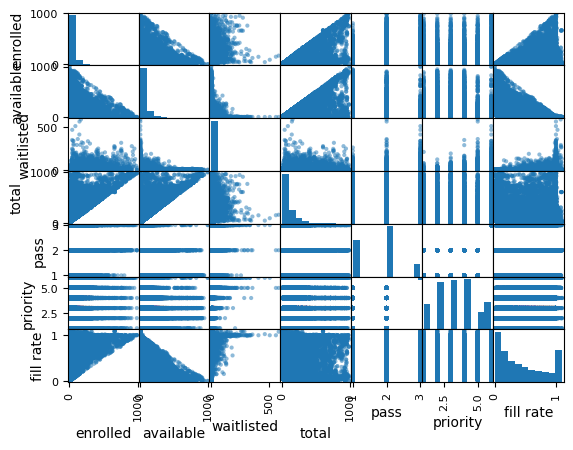

In [30]:
fig1 = pd.plotting.scatter_matrix(df)

It can be seen from the visualizations above that the columns 'enrolled', 'available', 'waitlisted', and 'total' exhibit a linear relationship, as one would expect.

Let's explore the distributions of some of these columns.

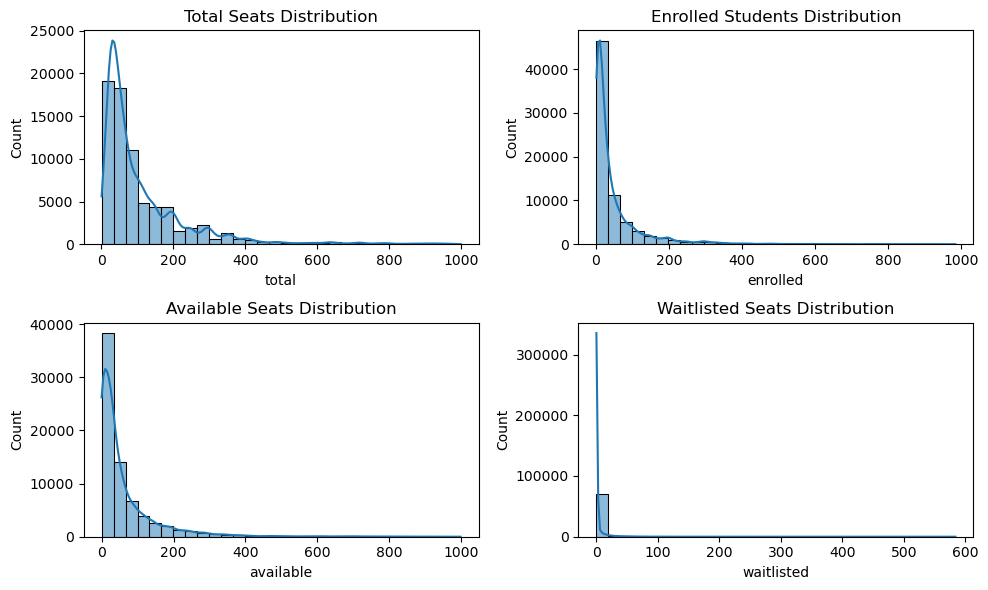

In [31]:
fig2, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# distribution of total seats
sns.histplot(x='total', bins=30, kde=True, data=df, ax=axes[0])
axes[0].set_title("Total Seats Distribution")

# distribution of enrolled seats
sns.histplot(x='enrolled', bins=30, kde=True, data=df, ax=axes[1])
axes[1].set_title("Enrolled Students Distribution")

# distribution of available seats
sns.histplot(x='available', bins=30, kde=True, data=df, ax=axes[2])
axes[2].set_title("Available Seats Distribution")

# distribution of waitlisted seats
sns.histplot(x='waitlisted', bins=30, kde=True, data=df, ax=axes[3])
axes[3].set_title("Waitlisted Seats Distribution")

plt.tight_layout()
plt.show()

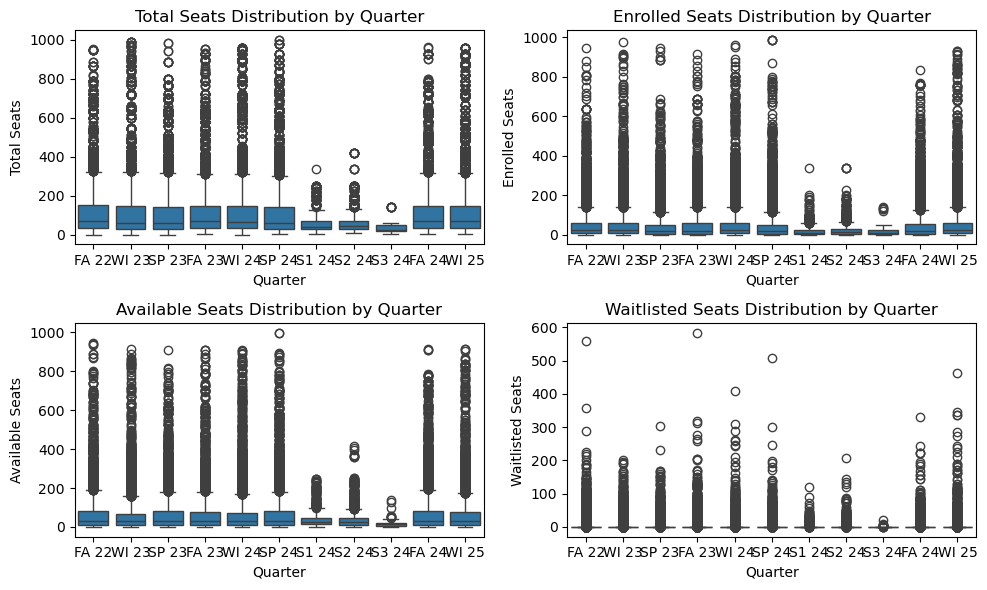

In [32]:
fig3, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# distribution of total seats by quarter
sns.boxplot(x="quarter", y="total", data=df, ax=axes[0])
axes[0].set_xlabel("Quarter")
axes[0].set_ylabel("Total Seats")
axes[0].set_title("Total Seats Distribution by Quarter")

# distribution of enrolled seats by quarter
sns.boxplot(x="quarter", y="enrolled", data=df, ax=axes[1])
axes[1].set_xlabel("Quarter")
axes[1].set_ylabel("Enrolled Seats")
axes[1].set_title("Enrolled Seats Distribution by Quarter")

# distribution of available seats by quarter
sns.boxplot(x="quarter", y="available", data=df, ax=axes[2])
axes[2].set_xlabel("Quarter")
axes[2].set_ylabel("Available Seats")
axes[2].set_title("Available Seats Distribution by Quarter")

# distribution of waitlisted seats by quarter
sns.boxplot(x="quarter", y="waitlisted", data=df, ax=axes[3])
axes[3].set_xlabel("Quarter")
axes[3].set_ylabel("Waitlisted Seats")
axes[3].set_title("Waitlisted Seats Distribution by Quarter")

plt.tight_layout()
plt.show()

From the histogram plots of these columns, it can be clearly seen that the distributions are all right-skewed. This is not surprising, as most class sizes are typically less than 300 as seen from the box plots above.

Let's also plot the distribution of fill rates to see if any interesting patterns emerge.

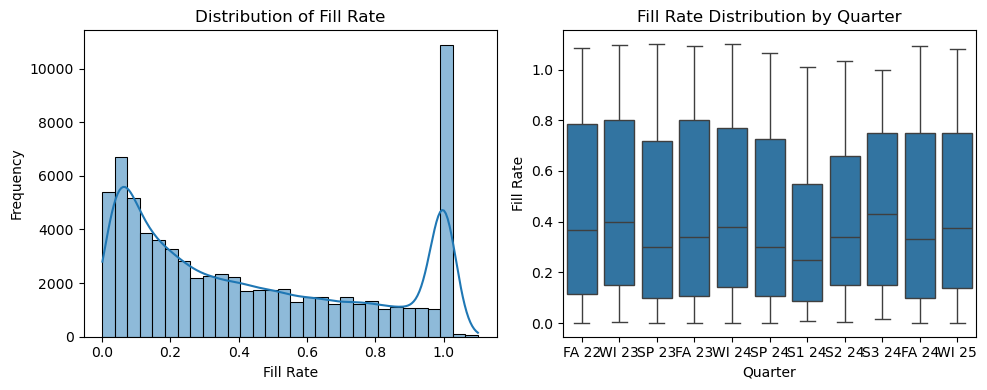

In [33]:
fig4, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

# distribution of fill rate
sns.histplot(x="fill rate", bins=30, kde=True, data=df, ax=axes[0])
axes[0].set_xlabel("Fill Rate")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Fill Rate")

sns.boxplot(x="quarter", y="fill rate", data=df, ax=axes[1])
axes[1].set_xlabel("Quarter")
axes[1].set_ylabel("Fill Rate")
axes[1].set_title("Fill Rate Distribution by Quarter")

plt.tight_layout()
plt.show()

Let's plot the number of available seats by our variables of interest: pass and priority.

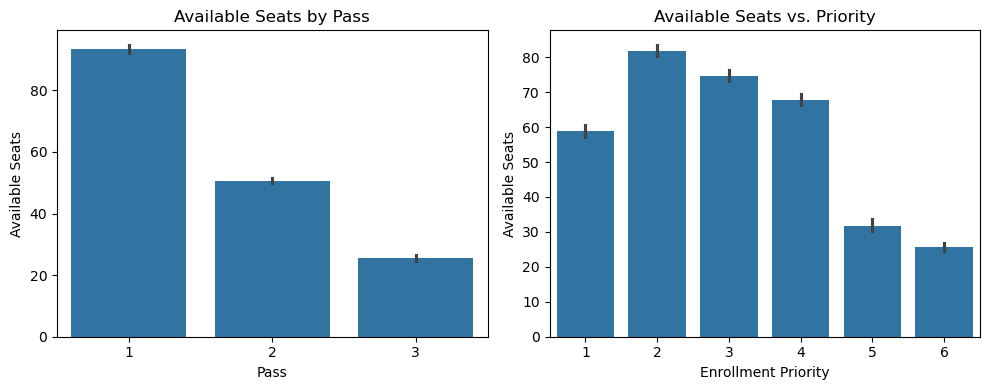

In [34]:
fig4, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

# number of available seats by pass
sns.barplot(x="pass", y="available", data=df, ax=axes[0])
axes[0].set_xlabel("Pass")
axes[0].set_ylabel("Available Seats")
axes[0].set_title("Available Seats by Pass")

# number of available seats vs. priority
sns.barplot(x="priority", y="available", data=df, ax=axes[1])
axes[1].set_xlabel("Enrollment Priority")
axes[1].set_ylabel("Available Seats")
axes[1].set_title("Available Seats vs. Priority")

plt.tight_layout()
plt.show()

Number of available seats seems to be decrease with later passes, which is consistent with our expectations. The number of available seats also follows a similar trend. However, there seems to be fewer available seats for seniors than juniors, which is surprising. There are possibly numerous reasons for this, some of which include delays in accurately entering the number of seats for a course on the first day of first pass.

Next, let's look at the distribution of courses across departments, starting with the number of courses offered by each department and computing the top ten most enrolled courses overall.

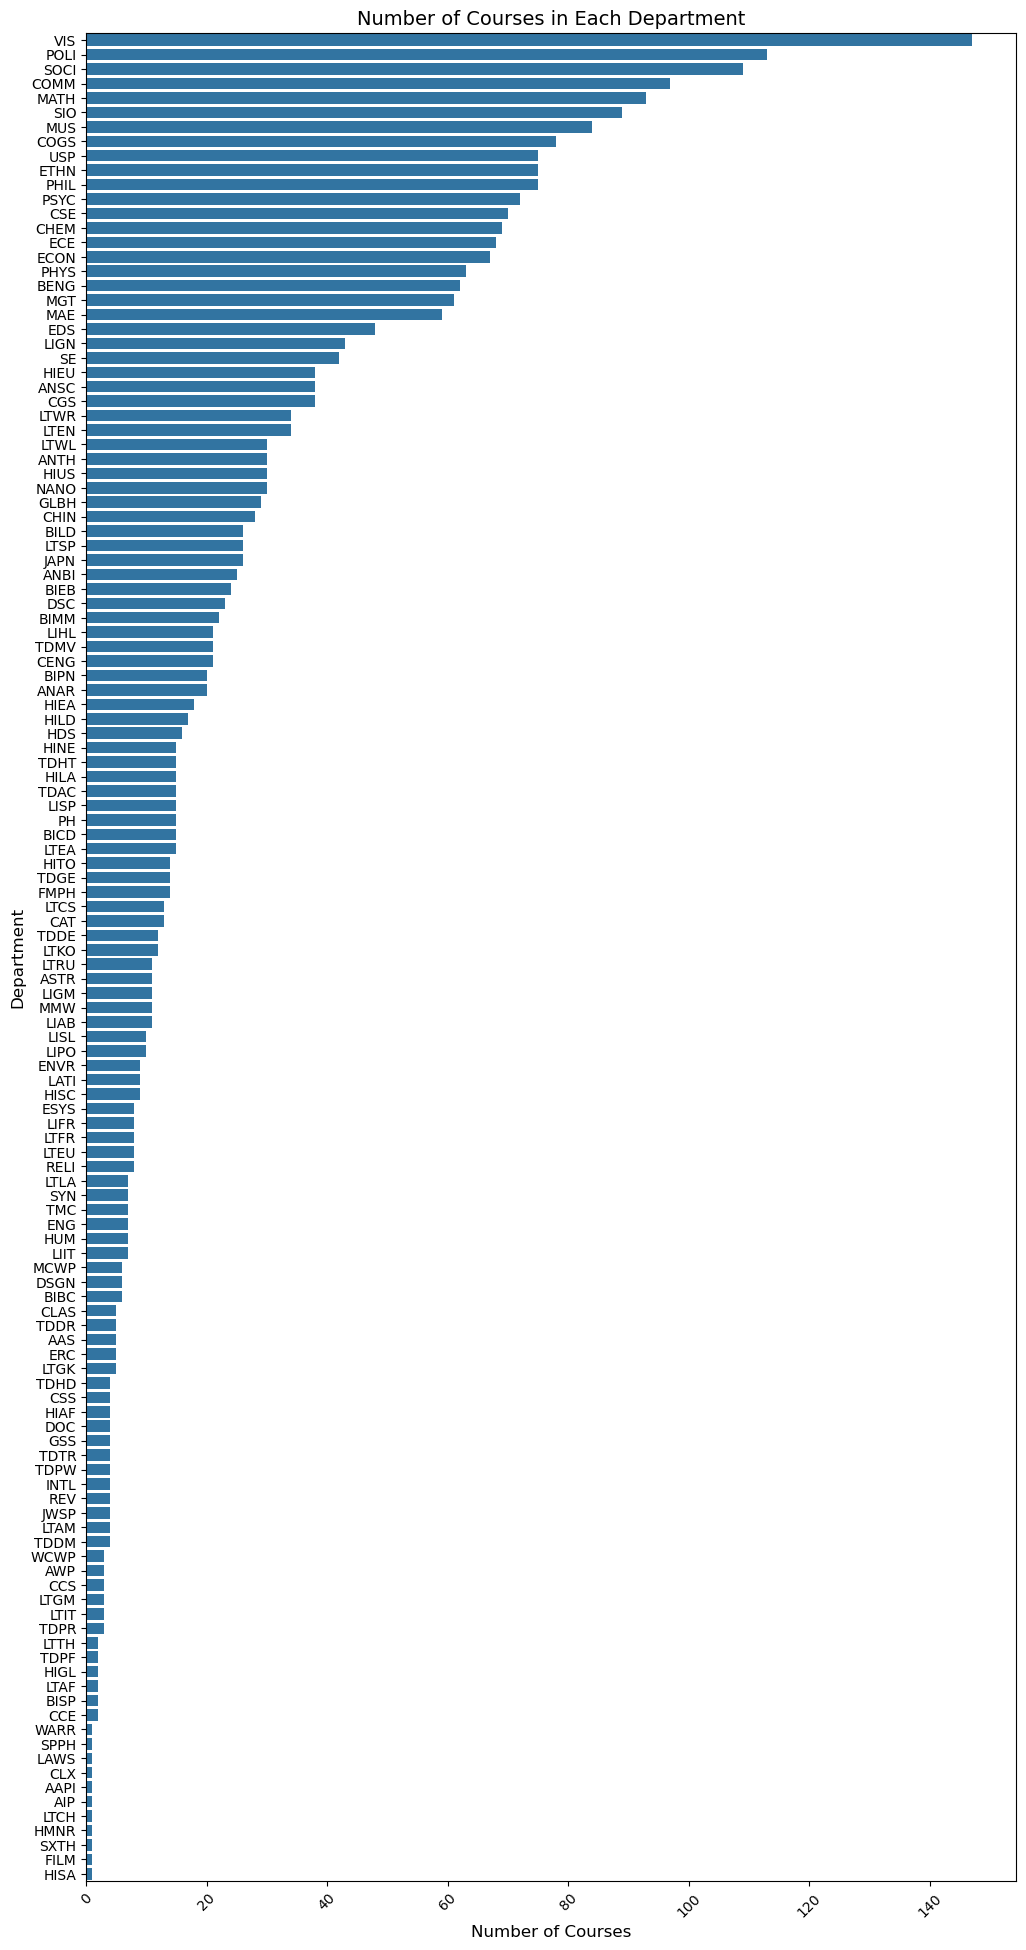

In [35]:
depts = pd.Series(df["course"].unique()).str.split().str[0]

# Count the number of courses per department
dept_counts = depts.value_counts()

# Plot bar chart
plt.figure(figsize=(12, 24))
sns.barplot(y=dept_counts.index, x=dept_counts.values)

# Add labels and title
plt.ylabel("Department", fontsize=12)
plt.xlabel("Number of Courses", fontsize=12)
plt.title("Number of Courses in Each Department", fontsize=14)
plt.xticks(rotation=45)  # Rotate for readability

# Show the plot
plt.show()

Let's also compute the mean fill rate for each department.

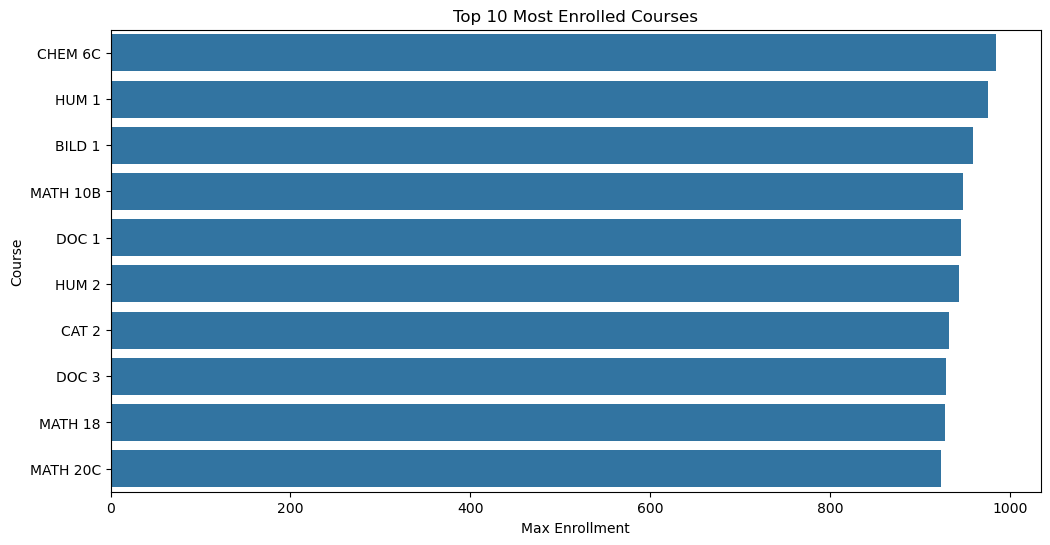

In [36]:
# top ten most enrolled courses
top_courses = df.groupby("course")["enrolled"].max().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_courses.values, y=top_courses.index)
plt.xlabel("Max Enrollment")
plt.ylabel("Course")
plt.title("Top 10 Most Enrolled Courses")
plt.show()

/tmp/ipykernel_2490/2668058843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['department'] = df["course"].str.split().str[0]


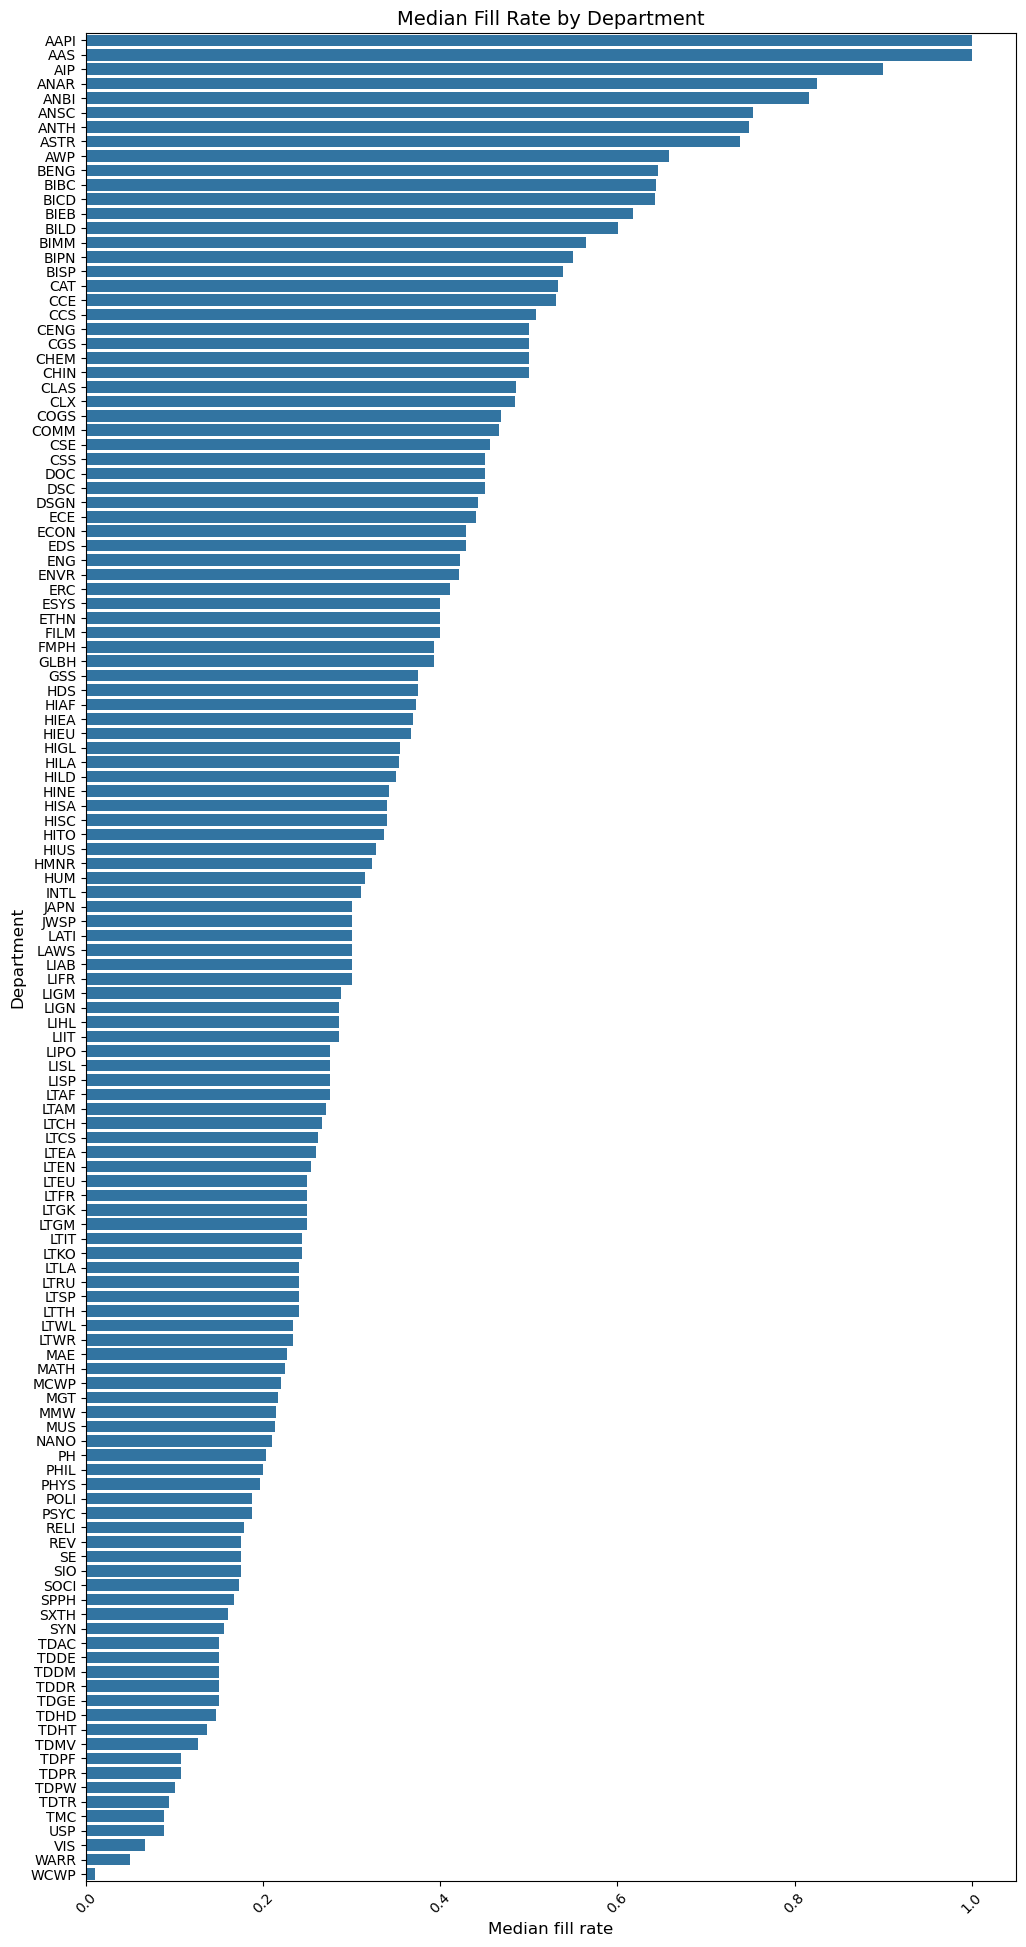

In [37]:
df['department'] = df["course"].str.split().str[0]
df

avg_fill_rate_by_dept = df.groupby('department')['fill rate'].median()
avg_fill_rate_by_dept

# Plot bar chart
plt.figure(figsize=(12, 24))
sns.barplot(y=avg_fill_rate_by_dept.index, x=avg_fill_rate_by_dept.sort_values(ascending=False))

# Add labels and title
plt.ylabel("Department", fontsize=12)
plt.xlabel("Median fill rate", fontsize=12)
plt.title("Median Fill Rate by Department", fontsize=14)
plt.xticks(rotation=45)  # Rotate for readability

# Show the plot
plt.show()

The graph above shows in descending order the median fill rates by departments. This gives us an insight into how 'full' certain departments are over others which will be important for predicting which classes should be taken during first pass, second pass, and third pass respectively. 

The cell below allows you to explore the trend in the number of available seats over the course of first, second, and third pass for any given course in a specific quarter.

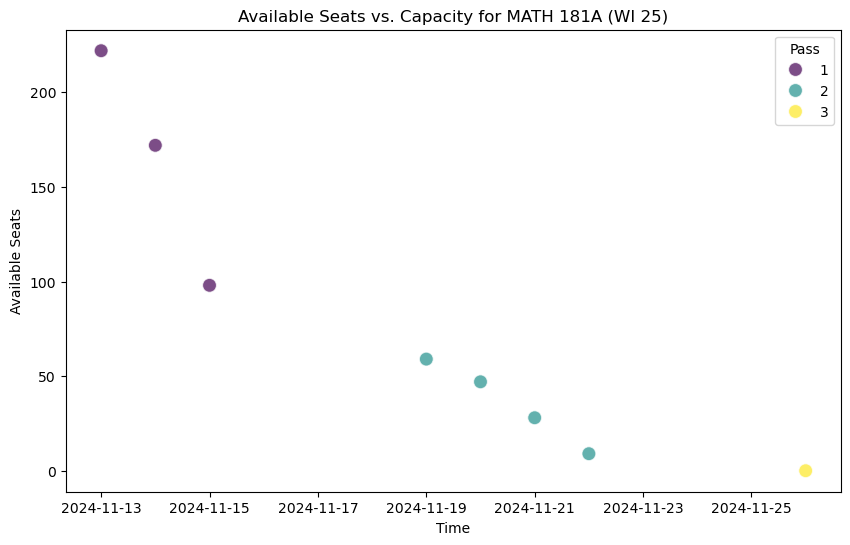

In [38]:
course_name = "MATH 181A"  # Change to the course you want
quarter_name = "WI 25"  # Change to the quarter you want

# Filter the dataframe for the specific course and quarter
df_filtered = df[(df["course"] == course_name) & (df["quarter"] == quarter_name)]

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="time", y="available", hue="pass", palette="viridis", s=100, alpha=0.7)

# Labels and title
plt.xlabel("Time")
plt.ylabel("Available Seats")
plt.title(f"Available Seats vs. Capacity for {course_name} ({quarter_name})")
plt.legend(title="Pass")  # Legend for first-pass vs. second-pass

# Show the plot
plt.show()

### Analysis

First, let's take a look at `fill rate` and its effect on seat `availability` as it can be used to help determine the effect of other variables. If there is a strong correlation, a strong effect on fill rate from other variables will also mean a strong effect on seat availability.

/tmp/ipykernel_2490/949657135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["available_bin"] = pd.cut(df["available"], bins=bins, labels=labels)
/tmp/ipykernel_2490/949657135.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=df["available_bin"], y=df["fill rate"], palette=colors)


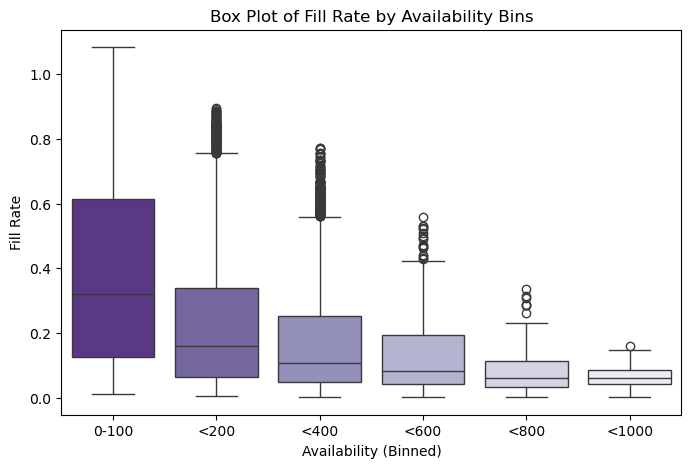

In [39]:
# Create bins for a cleaner plot
bins = [0, 100, 200, 400, 600, 800, 1000]
labels = ["0-100", "<200", "<400", "<600", "<800", "<1000"]
df["available_bin"] = pd.cut(df["available"], bins=bins, labels=labels)

# Create color gradient
colors = list(reversed(sns.color_palette("Purples", len(labels))))

# Creat box plot with gradient
plt.figure(figsize=(8,5))
ax = sns.boxplot(x=df["available_bin"], y=df["fill rate"], palette=colors)

# Customize labels
plt.xlabel("Availability (Binned)")
plt.ylabel("Fill Rate")
plt.title("Box Plot of Fill Rate by Availability Bins")

plt.show()

In [40]:
# Calculate Pearson correlation between available seats and fill rate
corr, p_val = stats.pearsonr(df['available'], df['fill rate'])
print(f"Pearson Correlation: {corr}, p-value: {p_val}")

# Print interpretation
if p_val < 0.05:
    print("There is a significant correlation between available seats and fill rate.")
else:
    print("No significant correlation found.")

Pearson Correlation: -0.4185928529468743, p-value: 0.0
There is a significant correlation between available seats and fill rate.


From these box plots, we can observe that at higher fill rates, there tend to be a fewer number of available seats. From the calculated Pearson correlation, we get a p-value that is so small that it returns as 0, indicating that there is a very strong negative correlation between available seats and fill rate. 

Since there is such a significant correlation, we can now compare `fill rate` to course `capacity`. 

/tmp/ipykernel_2490/661747716.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["capacity_bin"] = pd.cut(df["total"], bins=bins, labels=labels)
/tmp/ipykernel_2490/661747716.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=df["capacity_bin"], y=df["fill rate"], palette=colors)


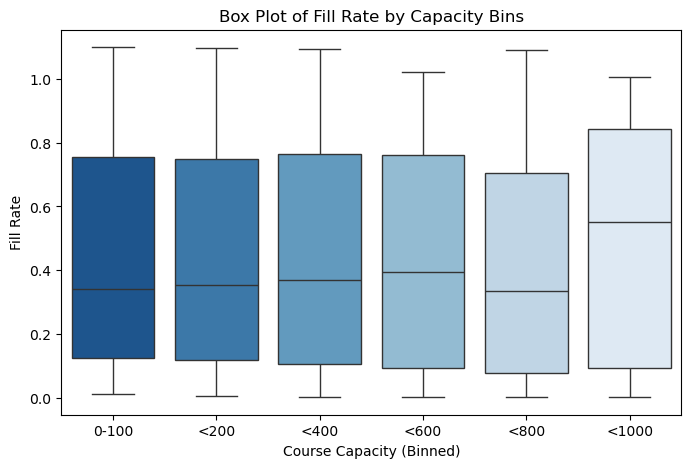

In [41]:
# Create bins for a cleaner plot
bins = [0, 100, 200, 400, 600, 800, 1000]
labels = ["0-100", "<200", "<400", "<600", "<800", "<1000"]
df["capacity_bin"] = pd.cut(df["total"], bins=bins, labels=labels)

# Create color gradient
colors = list(reversed(sns.color_palette("Blues", len(labels))))

# Creat box plot with gradient
plt.figure(figsize=(8,5))
ax = sns.boxplot(x=df["capacity_bin"], y=df["fill rate"], palette=colors)

# Customize labels
plt.xlabel("Course Capacity (Binned)")
plt.ylabel("Fill Rate")
plt.title("Box Plot of Fill Rate by Capacity Bins")

plt.show()

In [42]:
# Calculate Pearson correlation between capacity and fill rate
corr, p_val = stats.pearsonr(df['total'], df['fill rate'])
print(f"Pearson Correlation: {corr}, p-value: {p_val}")

# Print interpretation
if p_val < 0.05:
    print("There is a significant correlation between capacity and fill rate.")
else:
    print("No significant correlation found.")

Pearson Correlation: 6.229567276132665e-05, p-value: 0.9865938383473972
No significant correlation found.


We already intuitively know that a larger capacity will mean that there will be more seats. For example, a course with a capacity of 20 will already have fewer seats than a course with a capacity of 200. This doesn't necessarily mean that it determines how difficult it will be to secure a seat though. There could be a difference in demand that makes the course of 200 capacity fill up faster (have a high fill rate), and thus having fewer available seats, than the course of 20 capacity which barely fills up at all (low fill rate). 

The graph above looks into how fast courses of a different range of capacities fill up. From this, we can see that across all ranges in capacity, the median fill rate stays mostly consistent, except for the courses between 800-1000, which are higher. Even so, there needs to be a negative correlation to determine that course capacity has an impact on available seats as it would show how a smaller capacity would mean that it is in high demand, therefore filling up faster, making it less likely to have available seats. However, there is no correlation at all, as confirmed by a large p-value from the calculated Pearson correlation. So, we can conclude that capacity does not affect available seats.

Now let’s analyze how enrollment counts differ across `priority` levels and `quarters`. 

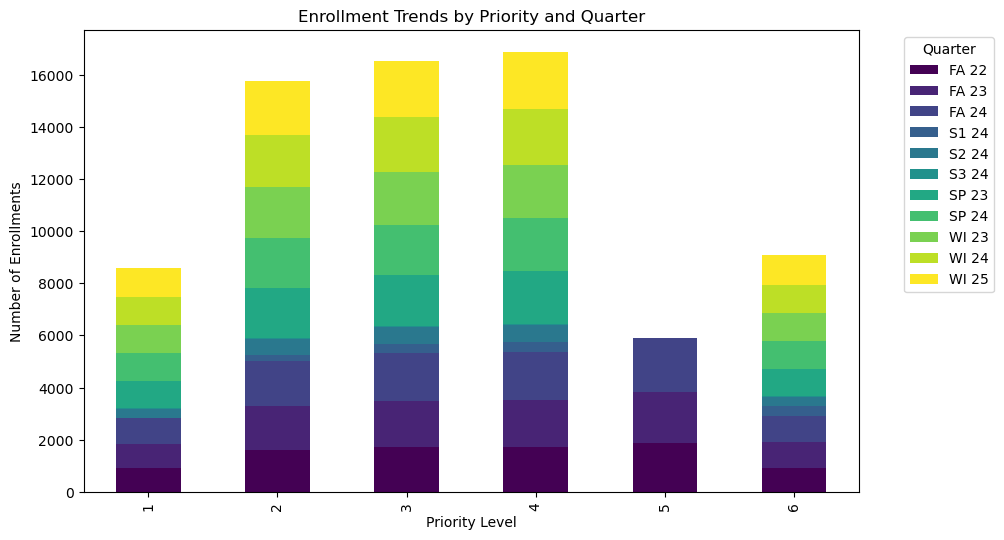

In [43]:
# group and count enrollments by priority and quarter
enrollment_trends = df.groupby(['priority', 'quarter']).size().unstack()

# plot results
enrollment_trends.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Enrollment Trends by Priority and Quarter")
plt.xlabel("Priority Level")
plt.ylabel("Number of Enrollments")
plt.legend(title="Quarter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

From the bar chart above, it can be seen that the higher priority levels (1–4) dominate enrollments across all quarters, with each reaching approximately 16,000 enrollments. Meanwhile, lower priority levels (5–6) exhibit fewer enrollments, around 10,000 and 6,000, respectively. This reflects a significant disparity in course access or demand as priority decreases.

Seasonal trends are also evident in the data. Fall quarters (FA 22, FA 23, FA 24) consistently show a higher number of enrollments compared to Spring quarters (SP 23, SP 24). For example, Priority Level 1 has approximately **12,000 enrollments in Fall quarters**, which is about **50% higher** than the **8,000 enrollments** observed in Spring quarters. These patterns suggest that Fall quarters, typically marking the start of the academic year, experience greater enrollment activity.

Having explored enrollment trends, we now shift to fill rate analysis to quantify course utilization and its impact on seat availability.

In [44]:
# calculate fill_rate as the ratio of enrolled to total
df['fill_rate'] = df['enrolled'] / df['total']
# handle cases where 'total' might be 0 to prevent division by zero
df['fill_rate'] = df['enrolled'] / df['total'].replace(0, float('nan'))

/tmp/ipykernel_2490/1331048411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fill_rate'] = df['enrolled'] / df['total']
/tmp/ipykernel_2490/1331048411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fill_rate'] = df['enrolled'] / df['total'].replace(0, float('nan'))


After calculating the `fill_rate` as the ratio of enrolled students to total course capacity, the updated dataset includes the following columns

In [45]:
df.head()

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate,department,available_bin,capacity_bin,fill_rate
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,2,0.044118,AAS,0-100,0-100,0.044118
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3,0.088235,AAS,0-100,0-100,0.088235
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,4,0.088235,AAS,0-100,0-100,0.088235
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,1,0.470588,AAS,0-100,0-100,0.470588
5,2022-05-28,31.0,37.0,0.0,68.0,AAS 10,FA 22,2,2,0.455882,AAS,0-100,0-100,0.455882


Next, it is important to explore how fill rates vary across priority levels and quarters to observe key patterns in course utilization. To do this, the average fill rates were aggregated into a pivot table and visualized using a heatmap.

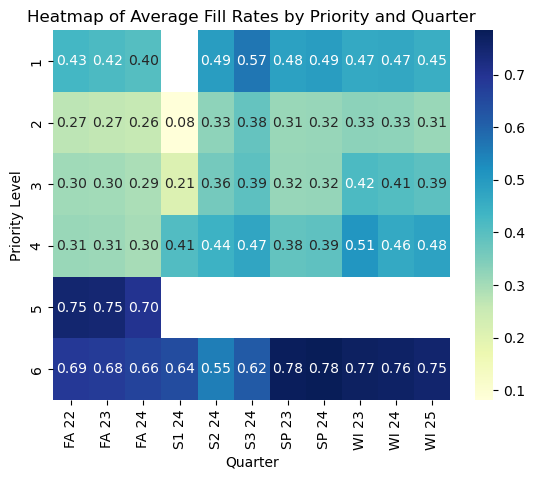

In [46]:
# pivot table for heatmap
pivot = df.pivot_table(values="fill_rate", index="priority", columns="quarter", aggfunc="mean")

# generate heatmap
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Heatmap of Average Fill Rates by Priority and Quarter")
plt.xlabel("Quarter")
plt.ylabel("Priority Level")
plt.show()

From the heatmap, we observe that lower priority levels (1–4) tend to have lower fill rates, averaging between 0.15 and 0.43. This trend is consistent with expectations, as higher-priority students are typically granted earlier access to courses. In contrast, higher priority levels (5 and 6) exhibit significantly higher fill rates, often exceeding 0.5, reflecting their advantage in enrolling in high-demand courses.

Fill rates appear relatively stable across Fall quarters (e.g., FA 22, FA 23, and FA 24), with higher utilization rates compared to other terms. However, there is noticeable variability in Spring quarters (e.g., SP 23 and SP 24) and greater inconsistency in Summer quarters (S1 24, S2 24, and S3 24). For example, Priority 4 in S2 24 experiences a spike in fill rate, possibly due to increased demand or reduced course availability. Conversely, Priority 1 in S1 24 shows almost no enrollment, which may suggest limited course offerings for this group during that term.

Additionally, specific quarters highlight the gap in access across priorities. For instance, Priority 5 in FA 22 achieves the highest average fill rate (0.71), closely followed by Priority 6 in SP 23 (0.72). Meanwhile, lower priorities, such as Priority 1, consistently experience significantly lower access to courses, illustrating a disadvantage for these groups.

Okay so now when it comes to assess whether the observed differences in average fill rates across priority levels are statistically significant, we perform a one-way Analysis of Variance (ANOVA). This test evaluates whether the mean fill rates differ significantly between the groups (priority levels).

In [47]:
df_cleaned = df.dropna(subset=["fill_rate"])
from scipy.stats import f_oneway

# group fill rates by priority
groups_priority = [group["fill_rate"] for _, group in df_cleaned.groupby("priority")]
f_stat, p_value = f_oneway(*groups_priority)

print(f"ANOVA Test - F-Statistic: {f_stat}, P-Value: {p_value}")

ANOVA Test - F-Statistic: 3542.532840957144, P-Value: 0.0


While the ANOVA test indicates that there are significant differences in mean fill rates across priority levels, it does not specify which priority levels differ from one another. So lets address this by performing Tukey's Honest Significant Difference (HSD) test as a post-hoc analysis. This test will compare all possible pairs of priority levels to determine where the significant differences lie.

In [48]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# conduct Tukey's HSD post-hoc test
tukey = pairwise_tukeyhsd(endog=df_cleaned["fill_rate"], groups=df_cleaned["priority"], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.1551    0.0 -0.1671 -0.1432   True
     1      3  -0.1089    0.0 -0.1207  -0.097   True
     1      4  -0.0529    0.0 -0.0647 -0.0411   True
     1      5   0.2777    0.0  0.2626  0.2927   True
     1      6   0.2718    0.0  0.2584  0.2852   True
     2      3   0.0462    0.0  0.0363  0.0562   True
     2      4   0.1022    0.0  0.0924  0.1121   True
     2      5   0.4328    0.0  0.4191  0.4464   True
     2      6   0.4269    0.0  0.4151  0.4386   True
     3      4    0.056    0.0  0.0462  0.0657   True
     3      5   0.3865    0.0   0.373     0.4   True
     3      6   0.3806    0.0   0.369  0.3923   True
     4      5   0.3305    0.0   0.317   0.344   True
     4      6   0.3247    0.0  0.3131  0.3363   True
     5      6  -0.0059 0.8723 -0.0208   0.009  False
----------------------------------------------

After confirming with the ANOVA test that significant differences exist in average fill rates across priority levels, we used Tukey's Honest Significant Difference (HSD) test to determine which priority levels differ from one another. The results show that all pairwise comparisons between priority levels are statistically significant, with adjusted p-values of 0.0. This indicates that every priority level has meaningful differences in average fill rates compared to others.

The largest differences are observed between Priority 1 and the higher priorities. For instance, Priority 5 has a mean fill rate difference of 0.4444 compared to Priority 1, and Priority 6 has a difference of 0.4029. These values reflect the substantial disparity in course access between the lowest and highest priorities. Even adjacent priorities show significant differences, such as between Priority 5 and Priority 6, where the mean difference is small (-0.0415) but still significant. This suggests that students in Priority 5 maintain a slight advantage over those in Priority 6 when it comes to course access.

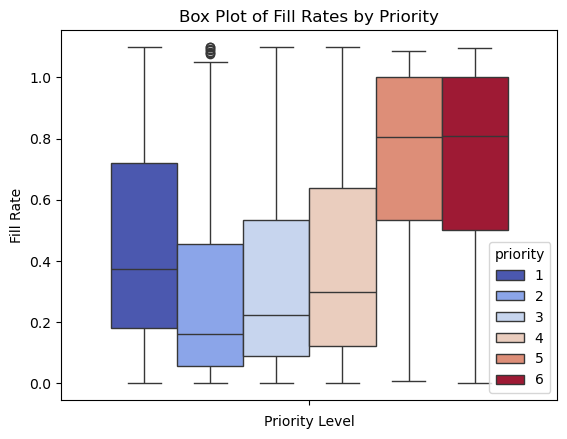

In [49]:
sns.boxplot(hue="priority", y="fill_rate", data=df_cleaned, palette="coolwarm")
plt.title("Box Plot of Fill Rates by Priority")
plt.xlabel("Priority Level")
plt.ylabel("Fill Rate")
plt.show()

To examine how fill rates differ across priority levels, a box plot was used to visualize the distribution of fill rates for each group. This visualization offers a detailed look at the range, median, and variability of fill rates within each priority, while also highlighting any outliers. The results align with prior findings, showing that higher priorities (5 and 6) tend to have higher median fill rates compared to lower priorities. These groups also display greater variability, suggesting a wider range of outcomes in course utilization. Conversely, lower priorities (1–4) generally exhibit lower median fill rates, with Priority 1 showing particularly low and tightly distributed values, indicating limited access to courses for this group.

Outliers appear across all priority levels, potentially reflecting courses that either reached full capacity or experienced unexpectedly low enrollment. An interesting observation is that Priority 6, despite being a high-priority group, has a slightly lower median fill rate than Priority 5. This aligns with the findings from Tukey’s HSD test and further illustrates how even within high-priority groups, disparities in course access can exist. Overall, the box plot provides valuable context for understanding the differences in course utilization across priorities and reinforces the advantage held by students with higher enrollment priorities.


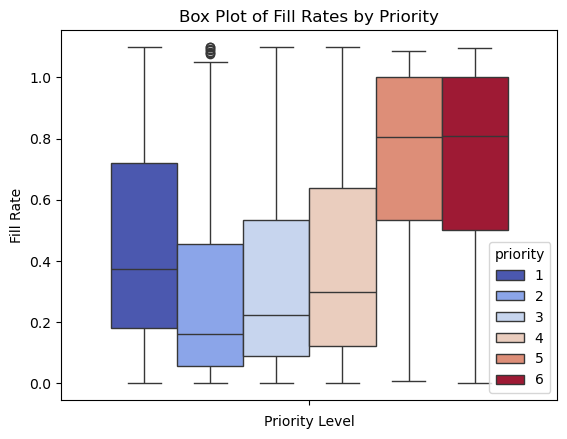

In [50]:
sns.boxplot(hue="priority", y="fill_rate", data=df_cleaned, palette="coolwarm")
plt.title("Box Plot of Fill Rates by Priority")
plt.xlabel("Priority Level")
plt.ylabel("Fill Rate")
plt.show()

### Summary of Findings

Our analysis indicates that fill rate has a more meaningful impact on seat availability as opposed to capacity strictly on its own. At higher fill rates, fewer seats tend to be available, and a strong correlation was shown. However, when looking at capacity in comparison to fill rate, we find that it does not significantly affect seat availability. Despite understanding that larger courses would have more seats, the lack of a correlation suggests that factors such as fill rate, rather than capacity alone, influence how quickly courses fill up. This reinforces our hypothesis that the speed at which a course fills plays a more critical role in determining seat availability than the course's maximum capacity.

Additionally, this analysis demonstrates the significant impact of enrollment priority levels and seasonal trends on course utilization. Higher-priority students consistently achieve greater access to courses, reflected in higher average fill rates and the statistically significant differences observed between priority groups. Seasonal patterns further reveal that Fall quarters typically see higher fill rates compared to Spring and Summer, indicating increased demand during the start of the academic year. These findings provide important insights into course accessibility and offer a foundation for strategies aimed at improving enrollment processes. Although this analysis provides valuable insights, it is limited by the absence of first-pass registration data. Including this information would allow for a more comprehensive understanding of how fill rates differ between first and second-pass registrations, providing a complete picture of enrollment trends.

# Ethics & Privacy

While the data is openly accessible, the method of data collection raises ethical considerations regarding automated data retrieval. It is essential to ensure that the scraping process does not access data we are not meant to use. However, the github uses the MIT License, and mentions that anyone is free to use this data. Since this repository is the only thing we scrape, we can address ethical concerns by simply citing this repository as our data source.

Although the data has no personally identifiable information (PII), there are some other privacy considerations. For example, enrollment trends and course availability data may indirectly reflect departmental or institutional scheduling strategies. Care must be taken to ensure that any analysis or publication of findings does not inadvertently expose proprietary or sensitive academic information.

Furthermore, there are potential biases in the datasets that may need to be addressed, particularly concerning data collection and representation. We may be analyzing data that has an overrepresentation of certain majors and class standings which leads to a biased analysis and recommendations. In addition to that, there may be subjective biases present in course and professor evaluations (CAPES) and instructor ratings from Rate My Professor. To identify and mitigate these biases, we will follow the Data Science Ethics Checklist. This includes conducting thorough data validation and exploratory data analysis (EDA) and implementing access controls to ensure data security as well as integrity. We will ensure that our visualizations and reports honestly represent the data and transparently document our analysis process. Any identified issues will be addressed through corrective measures such as weighting adjustments for underrepresented groups and/or incorporating additional data sources. As we complete all these ethical and privacy concerns throughout our project, we will produce fair, unbiased, and equitable recommendations for future use. 


# Team Expectations 

- Communication:
    - We will communicate via Discord, including texting and calling
    - The longest we expect to wait for a response is 24 hours 
    - We will meet at least once a week
    - Most, if not all, meetings will be done virtually
- Tone:
    - Be direct, but polite
        - Ex 1: “I think X is a problem because of Y. Does everyone else see it that way too or am I missing something?”
        - Ex 2: “I disagree with that idea because Z. What do you think if instead we try...”
- Decision Making:
    - Majority vote system for major decisions
    - Smaller decisions can be left to the person who is in charge of the task.
    - If a teammate is unresponsive when a decision has to be made quickly, it will be made without them using a majority vote.
- Tasks:
    - Members should first be assigned according to specialization, then others can oversee it to make sure everything aligns with expectations for that task
    - We will use GitHub issues for specific tasks and assignment deadlines. 
- Task completion issues
    - If you are struggling to deliver something you promised to do and haven’t made any progress on your own for 30+ minutes, let the group know through discord as soon as possible
    - Other group members who have the time outside of their own responsibilities and capability must respond within 24 hours
    - If no other members are available for help, the issue will be brought up during the following meeting time to discuss how to solve the problem and possibly reorganize the timeline to reflect that.



# Project Timeline Proposal

Specify your team's specific project timeline. An example timeline has been provided. Changes the dates, times, names, and details to fit your group's plan.

If you think you will need any special resources or training outside what we have covered in COGS 108 to solve your problem, then your proposal should state these clearly. For example, if you have selected a problem that involves implementing multiple neural networks, please state this so we can make sure you know what you’re doing and so we can point you to resources you will need to implement your project. Note that you are not required to use outside methods.



| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting | 
|---|---|---|---|
| 2/4  |  1 PM | Read & Think about COGS 108 expectations; brainstorm topics/questions  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 2/8  |  1 PM |  Do background research on topic | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 2/8  | 1 PM  | Edit, finalize, and submit proposal; Search for datasets  | Discuss Wrangling and possible analytical approaches; Assign group members to lead each specific part   |
| 2/20  | 6 PM  | Compress and merge Data - Chinmay - 16th Feb then Clean and Tidy Data, Add necessary columns - Anshul | Completion of Data wrangling   |
| 2/23  | 12 PM  | Discuss next steps for EDA | Complete project check-in |
| 3/6  | 12 PM  | Praveen and Chaela complete EDA by 3/1  | DiscussAnalysis |
| 3/9  | 12 PM  | Candice and Chaela complete analysis by 3/14 | Complete project check-in |
| 3/14  | 12 PM  | Complete Draft results/conclusion/discussion | Discuss/edit full project |
| 3/16  | 12 PM  | Finalize draft | Have final submission ready |
| 3/20  | Before 11:59 PM  | NA | Turn in Final Project & Group Project Surveys |